#### Вариант 13, Подопригорова C, ИУ5-64б

#### Задание. 

Для заданного набора данных (по Вашему варианту) постройте модели классификации или регрессии (в зависимости от конкретной задачи, рассматриваемой в наборе данных). Для построения моделей используйте методы 1 и 2 (по варианту для Вашей группы). Оцените качество моделей на основе подходящих метрик качества (не менее двух метрик). Какие метрики качества Вы использовали и почему? Какие выводы Вы можете сделать о качестве построенных моделей? Для построения моделей необходимо выполнить требуемую предобработку данных: заполнение пропусков, кодирование категориальных признаков, и т.д.

Методы: Линейная/логистическая регрессия, Градиентный бустинг

In [24]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
sns.set(style="ticks")

import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

In [26]:
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.02, a-0.05, str(round(b,3)), color='white')
        plt.show()  

In [27]:
data = pd.read_csv("marvel-wikia-data.csv")

# Проведение разведочного анализа данных. 

In [293]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16376 entries, 0 to 16375
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   page_id           16376 non-null  int64  
 1   name              16376 non-null  object 
 2   urlslug           16376 non-null  object 
 3   ID                12606 non-null  object 
 4   ALIGN             13564 non-null  object 
 5   EYE               6609 non-null   object 
 6   HAIR              12112 non-null  object 
 7   SEX               15522 non-null  object 
 8   GSM               90 non-null     object 
 9   ALIVE             16373 non-null  object 
 10  APPEARANCES       15280 non-null  float64
 11  FIRST APPEARANCE  15561 non-null  object 
 12  Year              15561 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.6+ MB


На основании предоставленного набора данных будем решать задачу классификации и предсказывать пол нерсонажей marvel.

# Предобработка данных

Рассмотрим пропуски в числовых данных

In [28]:
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка APPEARANCES. Тип данных float64. Количество пустых значений 1096, 6.69%.
Колонка Year. Тип данных float64. Количество пустых значений 815, 4.98%.


/Users/nonpenguin/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/nonpenguin/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


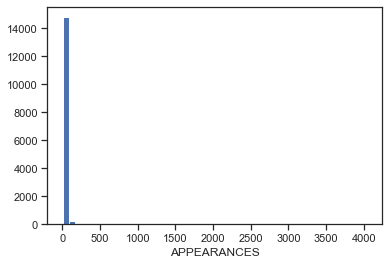

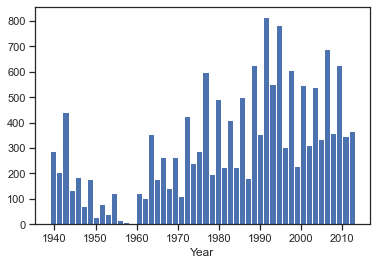

In [29]:
data_num = data[num_cols]
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

In [30]:
data['APPEARANCES'] = data['APPEARANCES'].fillna(data['APPEARANCES'].median())

In [31]:
data['Year'] = data['Year'].fillna(data['Year'].median())

Данных о гендерфлюидных и агендерных персонажах слишком мало, так что удалим эти категории вовсе. Мы будем решать задачу бинарной классификации. 

In [32]:
data[(data['SEX'] == 'Genderfluid Characters') | (data['SEX'] == 'Agender Characters')].count()

page_id             47
name                47
urlslug             47
ID                  33
ALIGN               45
EYE                 35
HAIR                40
SEX                 47
GSM                  2
ALIVE               47
APPEARANCES         47
FIRST APPEARANCE    38
Year                47
dtype: int64

In [33]:
data = data.drop(data[(data['SEX'] == 'Genderfluid Characters') | (data['SEX'] == 'Agender Characters')].index)

Рассмотрим пропуски в категориальных данных

In [34]:
cat_cols = []
for col in data.columns:
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка ID. Тип данных object. Количество пустых значений 3756, 22.94%.
Колонка ALIGN. Тип данных object. Количество пустых значений 2810, 17.16%.
Колонка EYE. Тип данных object. Количество пустых значений 9755, 59.57%.
Колонка HAIR. Тип данных object. Количество пустых значений 4257, 26.0%.
Колонка SEX. Тип данных object. Количество пустых значений 854, 5.21%.
Колонка GSM. Тип данных object. Количество пустых значений 16241, 99.18%.
Колонка ALIVE. Тип данных object. Количество пустых значений 3, 0.02%.
Колонка FIRST APPEARANCE. Тип данных object. Количество пустых значений 806, 4.92%.


Мы можем заполнить колонки SEX, ALIVE, ALIGN и FIRST APPEARANCE. ID, HAIR. Остальные столбцы удалим.

In [35]:
miss = ['SEX', 'ALIVE', 'ALIGN', 'FIRST APPEARANCE', 'ID', 'HAIR']

In [36]:
data[miss] = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit_transform(data[miss])

In [37]:
data = data.drop(['GSM', 'EYE'], axis = 1)

Закодируем категориальные данные

In [38]:
total_count = data.shape[0]
num_cols = []
for col in data.columns: 
    dt = str(data[col].dtype)
    if (dt=='object'):
        num_cols.append(col)        
        print('Колонка {}. Количество категорий: {}'.format(col, data[col].unique().shape[0]))

Колонка name. Количество категорий: 16329
Колонка urlslug. Количество категорий: 16329
Колонка ID. Количество категорий: 4
Колонка ALIGN. Количество категорий: 3
Колонка HAIR. Количество категорий: 25
Колонка SEX. Количество категорий: 2
Колонка ALIVE. Количество категорий: 2
Колонка FIRST APPEARANCE. Количество категорий: 832


Имя, ссылка на википедию и месяц первого появления вряд ли помогут нам определить пол персонажа, так что удалим эти признаки. Остальные закодируем OneHotEncoder

In [40]:
data = data.drop(['page_id', 'name', 'urlslug', 'FIRST APPEARANCE'], axis = 1)

In [41]:
from sklearn.preprocessing import LabelEncoder

categorical1 = ['SEX']

le = LabelEncoder()
for col in categorical1:
    data[col] = le.fit_transform(data[col])

In [42]:
categorical = ['ID', 'HAIR', 'ALIVE', 'ALIGN']

data = pd.concat([data, pd.get_dummies(data[categorical], columns=categorical, drop_first=True)],axis=1)
data.drop(categorical, axis=1, inplace=True)

Оценим дисбаланс классов для SEX

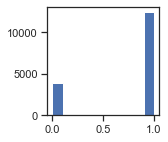

In [43]:
fig, ax = plt.subplots(figsize=(2,2)) 
plt.hist(data['SEX'])
plt.show()

In [44]:
total = data.shape[0]
class_0, class_1 = data['SEX'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 76.5%, а класс 1 составляет 23.5%.


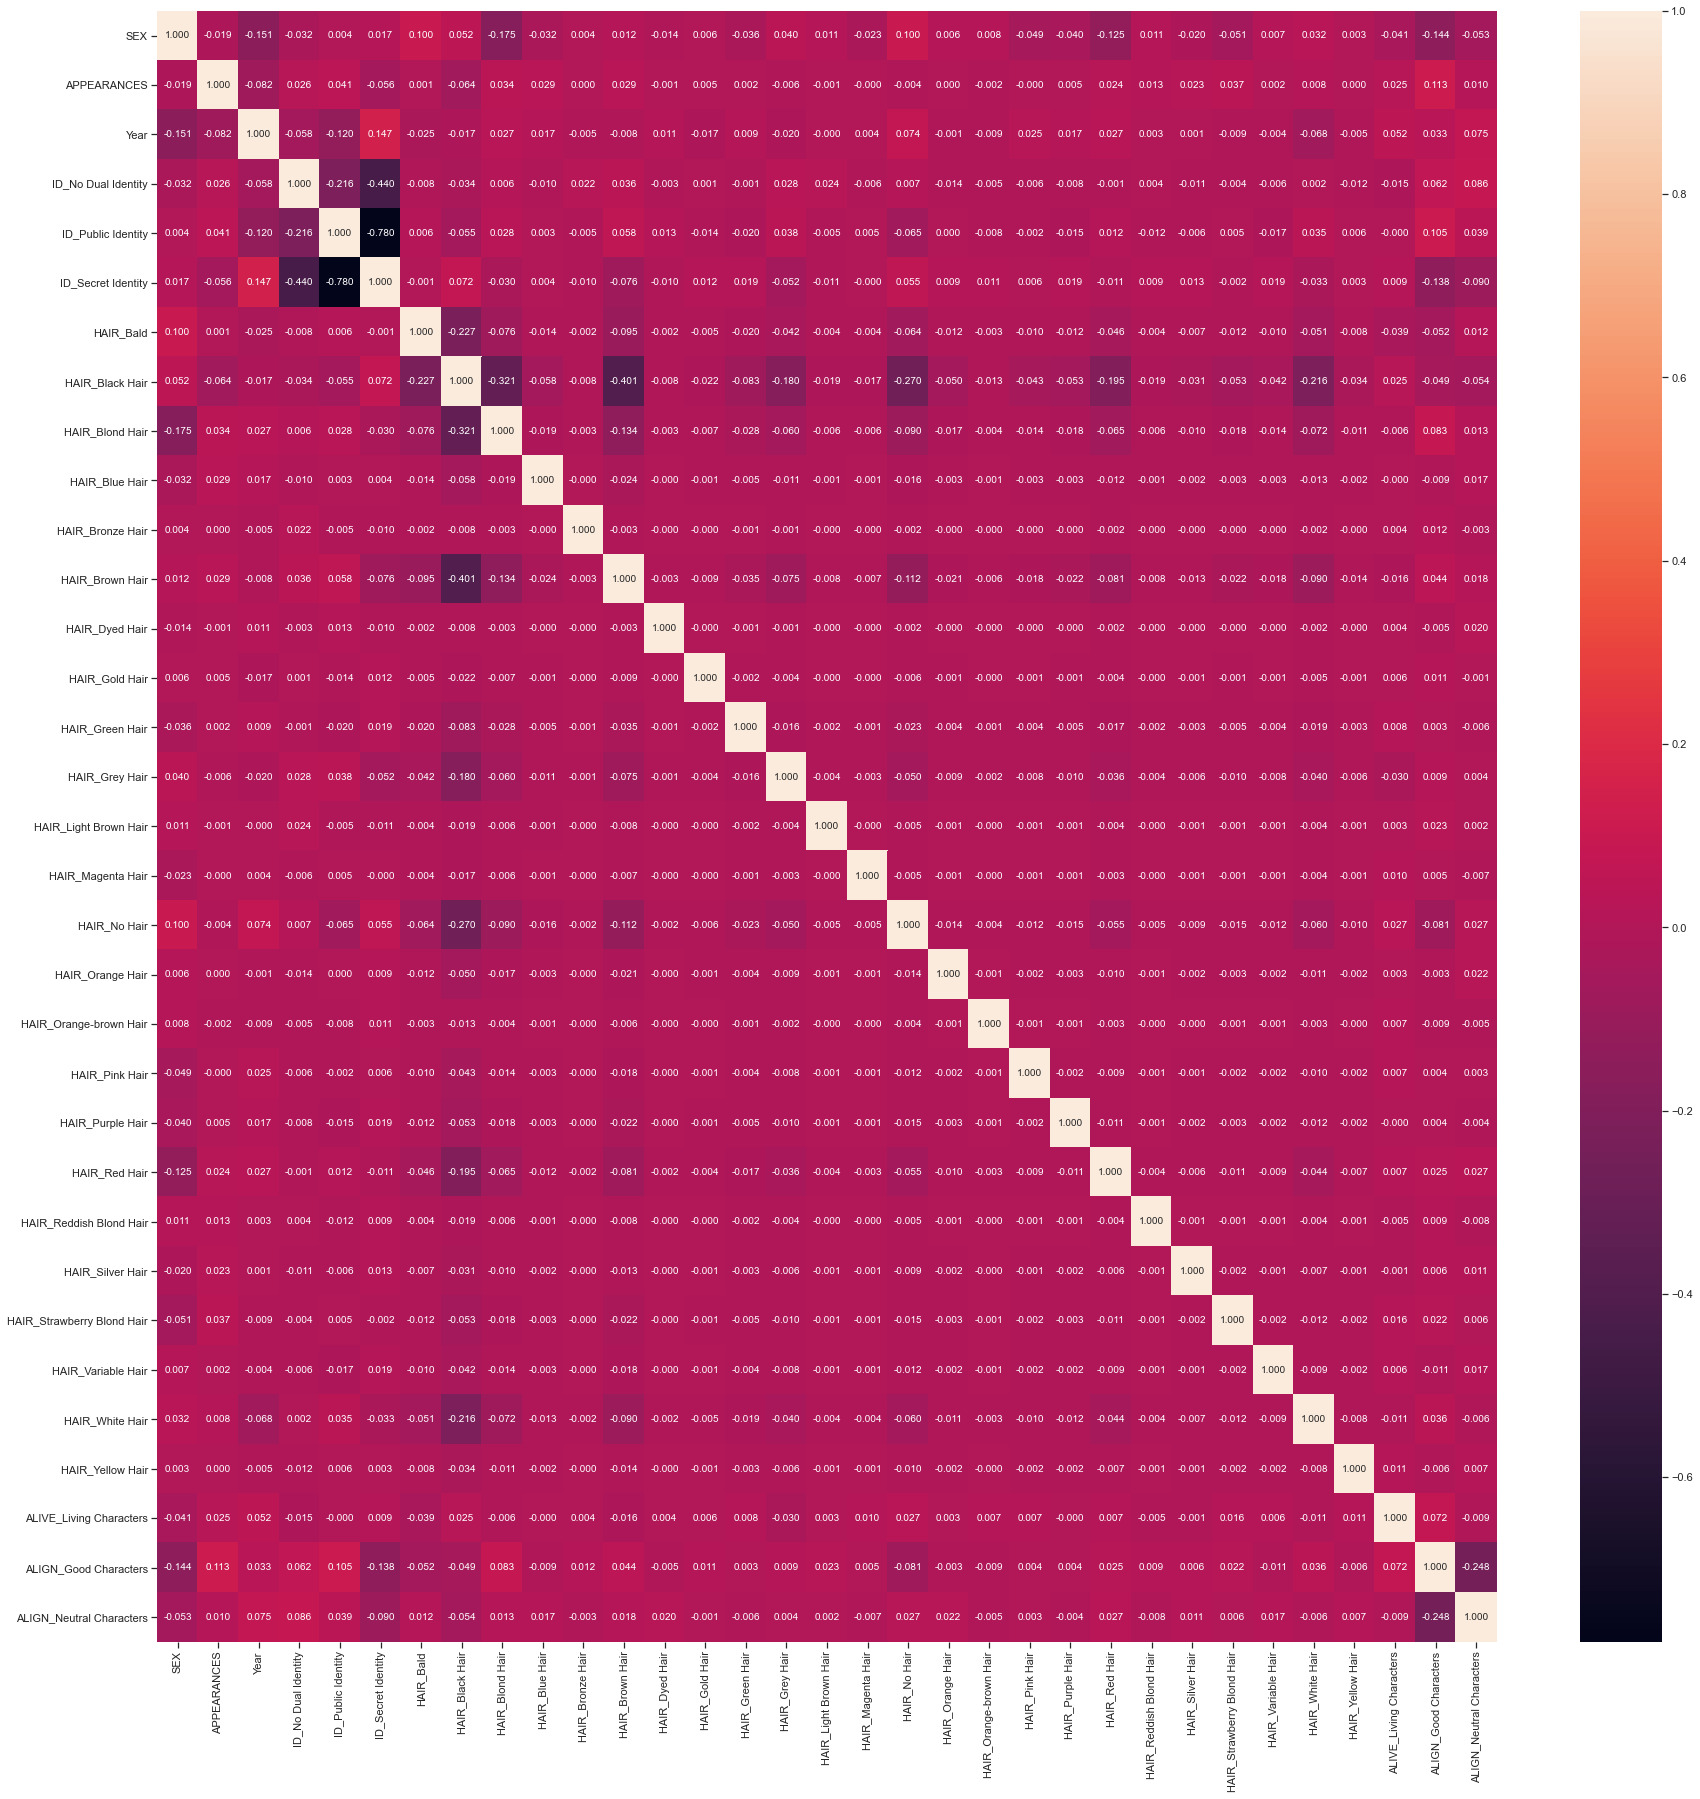

In [317]:
corrmat = data.corr()
plt.figure(figsize=(30,30))
sns.heatmap(corrmat, annot=True, fmt='.3f')

In [47]:
%%capture
y = data['SEX']
X = data[['Year', 'APPEARANCES', 'HAIR_Blond Hair', 'HAIR_Red Hair', 'HAIR_No Hair', 'ALIGN_Good Characters', 'ID_No Dual Identity', 'ALIVE_Living Characters']]

In [48]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X[:] = min_max_scaler.fit_transform(X)

<ipython-input-48-41496fa8968d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[:] = min_max_scaler.fit_transform(X)
/Users/nonpenguin/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

Для оценки качества построенных моделей классификации будем использовать метрики balanced accuracy (у нас бинарная классификация с заметным дисбалансом классов), precision (доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные), recall (доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов) и f1 score (среднее гармоническое от precision и recall). 

Также рассмотрим матрицы ошибок (количество верно и ошибочно классифицированных данных, представленное в виде матрицы).

In [50]:
metrics = MetricLogger()

# Логистическая регрессия

In [52]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [53]:
y_pred_log = model.predict(X_test)

accuracy = balanced_accuracy_score(y_test, y_pred_log)
precision = precision_score(y_test, y_pred_log, average='micro')
recall = recall_score(y_test, y_pred_log, average='micro')
f1 = f1_score(y_test, y_pred_log, average='micro')

metrics.add('accuracy', 'Logistic Regression', accuracy)
metrics.add('precision', 'Logistic Regression', precision)
metrics.add('recall', 'Logistic Regression', recall)
metrics.add('f1', 'Logistic Regression', f1)

print ("balanced_accuracy_score = {}".format(accuracy))
print ("precision_score = {}".format(precision))
print ("recall_score = {}".format(recall))
print ("f1_score = {}".format(f1))

balanced_accuracy_score = 0.5432391581658812
precision_score = 0.7714915503306392
recall_score = 0.7714915503306392
f1_score = 0.7714915503306392


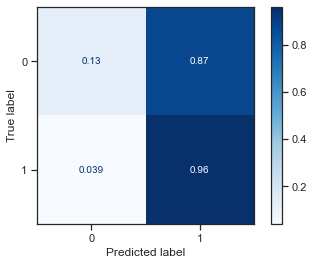

In [54]:
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, normalize='true') 

В выборке был дисбаланс, намного больше данных о персонажах мужского пола

# Градиентный бустинг

In [55]:
boost = GradientBoostingClassifier(random_state=0)
boost.fit(X_train, y_train)

GradientBoostingClassifier(random_state=0)

In [56]:
boost_prediction = boost.predict(X_test)

In [57]:
accuracy = balanced_accuracy_score(y_test, boost_prediction)
precision = precision_score(y_test, boost_prediction, average='micro')
recall = recall_score(y_test, boost_prediction, average='micro')
f1 = f1_score(y_test, boost_prediction, average='micro')

metrics.add('accuracy', 'Gradient Boosting', accuracy)
metrics.add('precision', 'Gradient Boosting', precision)
metrics.add('recall', 'Gradient Boosting', recall)
metrics.add('f1', 'Gradient Boosting', f1)

print ("balanced_accuracy_score = {}".format(accuracy))
print ("precision_score = {}".format(precision))
print ("recall_score = {}".format(recall))
print ("f1_score = {}".format(f1))

balanced_accuracy_score = 0.5552335716424461
precision_score = 0.7759000734753857
recall_score = 0.7759000734753857
f1_score = 0.7759000734753857


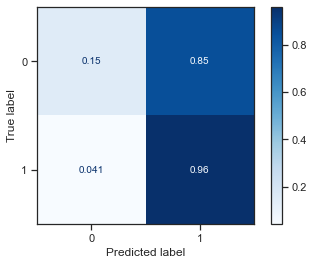

In [58]:
plot_confusion_matrix(boost, X_test, y_test, cmap=plt.cm.Blues, normalize='true') 

# Выводы

Сравнение метрик и объяснения, почему бустинг по жизни лучше

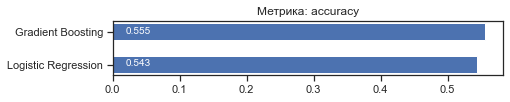

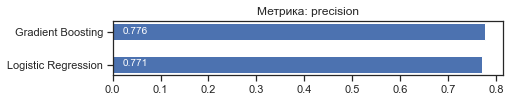

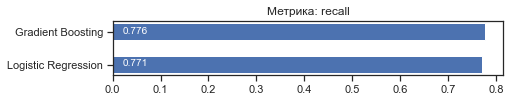

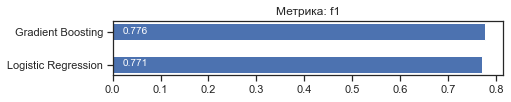

In [59]:
for metric in metrics.df['metric'].unique():
    metrics.plot('Метрика: ' + metric, metric, figsize=(7, 1))

Согласно четырём метрикам из четырёх градиентный бустинг показал лучшие результаты. Это свидетельствует о более сложной зависимости между данными, нежели линейная.